<a href="https://colab.research.google.com/github/EmersonVeras/faceRecognition/blob/main/Face_recogonition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import os
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
import glob
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_train = "/content/drive/MyDrive/computerVision/faces-classification/train"
path_test = "/content/drive/MyDrive/computerVision/faces-classification/test"
new_path_train = "/content/newImagesGrayTrain"
new_path_test = "/content/newImagesGrayTest"

# Other functions

## functions

In [ ]:
import cv2 as cv
import numpy as np
import argparse

"""
 - Article: 
 Empirical Comparisons of Several Preprocessing Methods for Illumination
                    Insensitive Face Recognition

# HE -> Histogram Equalization
# HS -> Histogram Specification
# LOG -> Logarithm Transform
# GIC -> Gamma intensity -> https://pyimagesearch.com/2015/10/05/opencv-gamma-correction/
# SQI -> Self-quotient image

"""

def transform_to_gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def histogram_equalization(img):
    image_bgr = img
    image_yuv = cv.cvtColor(image_bgr, cv.COLOR_BGR2YUV)
    image_yuv[:, :, 0] = cv.equalizeHist(image_yuv[:, :, 0])

    image_bgr = cv.cvtColor(image_yuv, cv.COLOR_YUV2BGR)
    return image_bgr   

def logarithm_transform(img):
    transform_to_log = 255/np.log(1 + np.max(img))
    log_image = transform_to_log * (np.log(img + 1))
    return np.array(log_image, dtype = np.uint8)
    
def adjust_gamma_intensity(img, gamma = 1.0):
    invGamma = 1.0/ gamma
    table = np.array([((i/ 255.0) ** invGamma) * 255.0
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv.LUT(img, table)

def self_quotient_image():
    pass

def bilateral_filter(img):
  return cv2.bilateralFilter(img, 10, 10, 50)

def sharpen(img):
    kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,10,-1], 
                              [-1,-1,-1]])
    return cv.filter2D(img, -1, kernel_sharpening)


# Get inputs

In [1]:
def list_all_inputs():
  base_dir = '/content/drive/...'
  people_1_dir = glob.glob(os.path.join(base_dir + 'people_1/', '*'))
  people_2_dir = glob.glob(os.path.join(base_dir + 'people_2/', '*'))
  people_3_dir = glob.glob(os.path.join(base_dir + 'people_3/', '*'))
  X_path = [people_1_dir, people_2_dir, people_3_dir]
  return X_path, ['people_1', 'people_2', 'people_3']

In [ ]:
X_path, labels = list_all_inputs()

In [ ]:
def create_input_labels(bilat_filter=False, hist_equalization=False, sharp=False):  
  X_path, labels = list_all_inputs()
  print("\nTotal # of inputs: {}".format(sum(map(len, X_path))))
  print("Labels: {}".format(labels))

  # Preprocessing
  if bilat_filter:
    print("Applying bilateral filter")
  if hist_equalization:
    print("Applying histogram equalization")
  if sharp:
    print("Applying sharpening")
  
  X = []
  y = []
  for i, (folder, label) in enumerate(zip(X_path, labels)):
    for f in folder:
      img = np.array(cv2.resize(cv2.imread(f), (224,224), interpolation = cv2.INTER_AREA))

      if bilat_filter:
        img = bilateral_filter(img)
      if hist_equalization:
        img = histogram_equalization(img)

      if sharp:
        img = sharpen(img)
      X.append(img)     
      y.append(i)

  X = np.array(X)
  X = X / 255

  y = to_categorical(y, 3)

  return X, y

In [ ]:
X, y = create_input_labels(bilat_filter=True, hist_equalization=True, sharp=True)


Total # of inputs: 135
Labels: ['felipe', 'emerson', 'luan']
Applying bilateral filter
Applying histogram equalization
Applying sharpening


In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(y)

numpy.ndarray

In [ ]:
import warnings 
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.model_selection import train_test_split 
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import random
import tensorflow as tf
import cv2 as cv
import os 
import glob

In [ ]:
import keras
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
def create_model():
  inp = Input((224,224,3))
  conv1 = Conv2D(64, (5,5), padding='valid', activation= 'relu')(inp)
  conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
  conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
  conv2 = BatchNormalization()(conv2)
  flat = Flatten()(conv2)
  dense1 = Dense(256, activation= 'relu')(flat)
  dense1 = Dropout(0.5)(dense1)
  dense2 = Dense(64, activation= 'relu')(dense1)
  dense2 = Dropout(0.1)(dense2)
  out = Dense(3, activation = 'softmax')(dense2)
  model = Model(inp, out)

  return model


# Without Filters

In [ ]:
def train_model(model, id, X_train, X_val, y_train, y_val):
  filepath = "output/" + id + '_TF-CNN.{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5'
  lr_red = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
    patience=3, verbose=1, factor=0.5, min_lr=0.000001)
  chkpoint = keras.callbacks.ModelCheckpoint(filepath, 
    monitor='val_accuracy', verbose=0, save_best_only=True, 
    save_weights_only=False, mode='auto', period=1)
  
  history_filename = 'output/' + id + '_log.csv'
  history_cb = tf.keras.callbacks.CSVLogger(history_filename, separator=",", append=False)
  model_metrics=['accuracy',                  
                  tf.keras.metrics.Precision(),                  
                  tf.keras.metrics.Recall(),
                  sensitivity,
                  specificity]
  model.compile(optimizer = Nadam(0.0001) , loss = 'categorical_crossentropy', 
    metrics=model_metrics)

  history = model.fit(X_train, y_train, batch_size = 1, epochs = 30, initial_epoch = 0, 
    validation_data = (X_val, y_val), callbacks=[lr_red, chkpoint, history_cb])
 
  prediction = model.predict(X_val)

  return prediction


In [ ]:
def main():
  # read data and create labels
  X, y = create_input_labels(hist_equalization=False, bilat_filter=False)

  # split train and test sets
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
  prediction = []
  model = create_model()
  model.summary()
  all_prediction = train_model(model, "CNN_bilat_equal_hist_sharp", X_train, X_val, y_train, y_val)


  print("prediction: ", all_prediction)
  return all_prediction
if __name__ == "__main__": 
  y_pred = main()
  


Total # of inputs: 135
Labels: ['felipe', 'emerson', 'luan']
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 110, 110, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 107, 107, 96)      98400     
                                                               

Epoch 1/30
108/108 [==============================] - 12s 97ms/step - loss: 4.9820 - accuracy: 0.6852 - precision_5: 0.6852 - recall_5: 0.6852 - sensitivity: 0.6852 - specificity: 0.8426 - val_loss: 3.0818 - val_accuracy: 0.2593 - val_precision_5: 0.2593 - val_recall_5: 0.2593 - val_sensitivity: 0.2593 - val_specificity: 0.6296 - lr: 1.0000e-04
Epoch 2/30
108/108 [==============================] - 7s 64ms/step - loss: 2.2277 - accuracy: 0.8981 - precision_5: 0.8981 - recall_5: 0.8981 - sensitivity: 0.8981 - specificity: 0.9491 - val_loss: 12.9236 - val_accuracy: 0.2593 - val_precision_5: 0.2593 - val_recall_5: 0.2593 - val_sensitivity: 0.2593 - val_specificity: 0.6296 - lr: 1.0000e-04
Epoch 3/30
108/108 [==============================] - 7s 63ms/step - loss: 0.1067 - accuracy: 0.9722 - precision_5: 0.9722 - recall_5: 0.9722 - sensitivity: 0.9722 - specificity: 0.9861 - val_loss: 15.0353 - val_accuracy: 0.2593 - val_precision_5: 0.2593 - val_recall_5: 0.2593 - val_sensitivity: 0.2593 - 

prediction:  [[0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.4606129e-31 3.7331402e-29]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.6837814e-05 9.8869842e-01 1.1284686e-02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+0

In [ ]:
y_pred_arg = np.argmax(y_pred, axis = 1)
y_pred

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.4606129e-31, 3.7331402e-29],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.000

In [ ]:
y_val_arg = np.argmax(y_val, axis = 1)
y_val_arg

array([2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 2, 1])

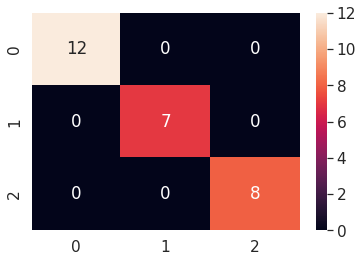

In [ ]:
import seaborn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_arg, y_pred_arg)
seaborn.set(font_scale = 1.4)
seaborn.heatmap(cm, annot=True);
plt.show()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt


def plot_metric(file, metrics=['sensitivity', 'precision_5']):
    plt.figure(figsize=(25,10))
    df = pd.read_csv(file)
    plt.subplot(1, 2, 1)

    metric = metrics[0]   
    plt.plot(df[metric])
    plt.plot(df['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')

    plt.subplot(1, 2, 2)
    metric = metrics[1]   
    plt.plot(df[metric])
    plt.plot(df['val_' + metric])
    plt.title('model ' + metric.replace("_5", " "))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')

    plt.show()


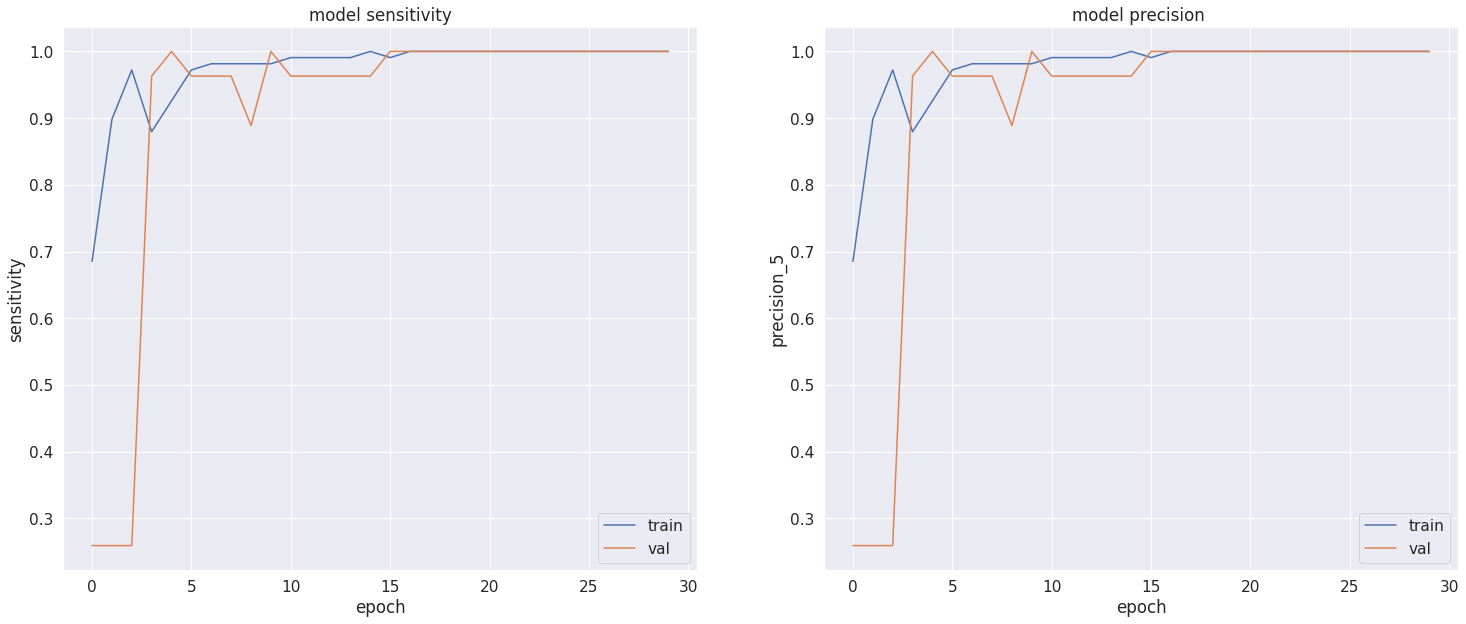

In [ ]:
plot_metric('/content/output/CNN_bilat_equal_hist_sharp_log.csv')